In [ ]:
# CIFAR-10 Classification with ResNet50 in PyTorch

import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
import torchvision.models as models
import matplotlib.pyplot as plt
import numpy as np

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data transforms (resize to 224x224 for ResNet50, normalize to ImageNet)
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(224, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])
transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])

# Load dataset
trainset = CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testset = CIFAR10(root='./data', train=False, download=True, transform=transform_test)

trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

# Load pretrained ResNet50 and modify
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 10)
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0, 0, 0
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    acc = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss:.4f}, Accuracy: {acc:.2f}%")

# Evaluation
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")


100%|████████████████████████████████████████████████████████████████████████████████| 170M/170M [04:26<00:00, 640kB/s]
D:\env2\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\env2\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\HP/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth


 16%|████████████▏                                                                 | 15.2M/97.8M [00:17<01:34, 912kB/s]

In [1]:
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
import torchvision.models as models
from tqdm import tqdm

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Transforms: resize to 128x128 (smaller than 224x224)
transform_train = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
transform_test = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Dataset and loader
trainset = CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testset = CIFAR10(root='./data', train=False, download=True, transform=transform_test)

trainloader = DataLoader(trainset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
testloader = DataLoader(testset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

# Model
model = models.resnet50(pretrained=True)

# Freeze all layers except classifier
for param in model.parameters():
    param.requires_grad = False
model.fc = nn.Linear(model.fc.in_features, 10)  # Replace classifier
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=1e-4)  # Only train classifier

# Training (fewer epochs)
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0, 0, 0
    loop = tqdm(trainloader, desc=f"Epoch {epoch+1}/{num_epochs}")
    for inputs, labels in loop:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        loop.set_postfix(loss=loss.item(), acc=100. * correct / total)

# Evaluation
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")


D:\env2\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\env2\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 5/5: 100%|█████████████████████████████████████████████████| 1563/1563 [05:08<00:00,  5.07it/s, acc=81.3, loss=1]


Test Accuracy: 82.28%


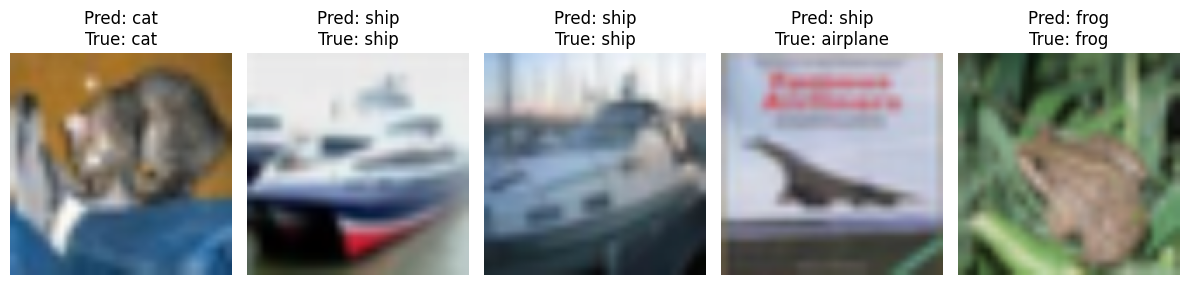

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# 8. Test on sample images
classes = trainset.classes
def imshow(img, title):
    img = img.cpu().numpy().transpose((1, 2, 0))
    img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # Unnormalize
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')

# Show 5 test images with predicted + actual labels
dataiter = iter(testloader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)
outputs = model(images)
_, preds = torch.max(outputs, 1)

plt.figure(figsize=(12, 6))
for i in range(5):
    plt.subplot(1, 5, i+1)
    imshow(images[i], f"Pred: {classes[preds[i]]}\nTrue: {classes[labels[i]]}")
plt.tight_layout()
plt.show()


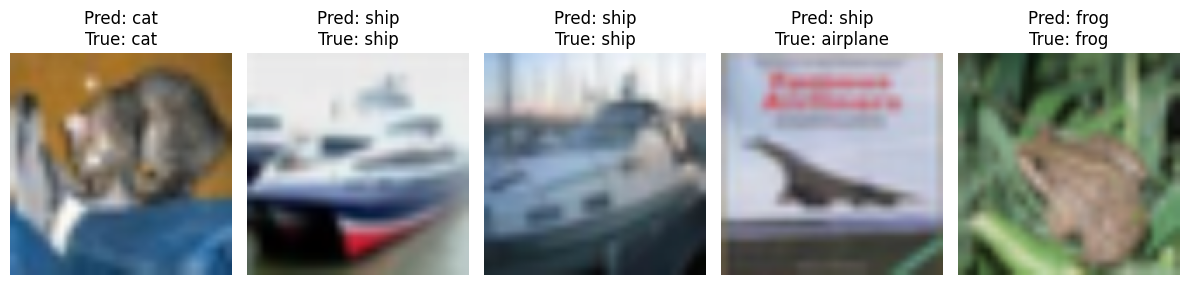

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# 8. Test on sample images
classes = trainset.classes
def imshow(img, title):
    img = img.cpu().numpy().transpose((1, 2, 0))
    img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # Unnormalize
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')

# Show 5 test images with predicted + actual labels
dataiter = iter(testloader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)
outputs = model(images)
_, preds = torch.max(outputs, 1)

plt.figure(figsize=(12, 6))
for i in range(5):
    plt.subplot(1, 5, i+1)
    imshow(images[i], f"Pred: {classes[preds[i]]}\nTrue: {classes[labels[i]]}")
plt.tight_layout()
plt.show()


In [ ]:
# ---- Show 15 Test Images with Predictions ----

import matplotlib.pyplot as plt
import numpy as np

# Class labels (e.g., ['airplane', 'automobile', ..., 'truck'])
classes = trainset.classes

# Unnormalize and show image
def imshow(img, title):
    img = img.cpu().numpy().transpose((1, 2, 0))
    img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # unnormalize
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')

# Load one batch from test set
dataiter = iter(testloader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)

# Make predictions
model.eval()
with torch.no_grad():
    outputs = model(images)
    _, preds = torch.max(outputs, 1)

# Plot 15 images in a 3x5 grid
num_images = 15
plt.figure(figsize=(18, 10))  # Wider figure to fit more images

for i in range(num_images):
    plt.subplot(3, 5, i+1)  # 3 rows, 5 columns
    imshow(images[i], f"Pred: {classes[preds[i]]}\nTrue: {classes[labels[i]]}")

plt.tight_layout()
plt.show()
